# Calibrating audio models

This notebook trains models for speech command recognition, and exports them as TFLITE.


## Adjustable parameters

Processing selection:
* offline processing: save spectrograms in advance and load them up during the execution of the TF graph
* online processing (TF-only: does not work with Rune proc block): compute spectrograms during the execution of the TF graph, just before passing them into the NN model

Pre-processing selection:
* if select PREPROCESS="rune", then it runs with pre-computed (with the 6-step wav->spectrogram pipeline) spectrograms from Rust
* if select PREPROCESS="micro", then it runs with audio clips plugged into a TF graph where the 6-step wav->spectrogram pipeline is applied

Language:
* English
* Estonian

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.ops import gen_audio_ops as audio_ops
from tensorflow.python.ops import io_ops
from tensorflow.python.platform import gfile
from tensorflow.python.util import compat

import pickle

import librosa
import numpy as np
import scipy.signal
import scipy.io.wavfile as wavfile
import tensorflow as tf
import os, sys

from matplotlib import pyplot as plt
from tensorflow.python.ops import io_ops
from tf_speech_commands import input_data, models

try:
    from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
except ImportError:
    frontend_op = None
    
from rune_py import Fft, NoiseFiltering
import subprocess

from tensorflow.python.platform import gfile
from six.moves import xrange  # pylint: disable=redefined-builtin
    
tf.__version__

'1.15.2'

# Define parameters for the model, and load the data to be used

In [36]:
#PREPROCESS = 'micro'
PREPROCESS = 'rune'

#PROCESSING = "online"
PROCESSING = "offline"

# Selection of command language / dataset for commands
if False: # Commands in Estonian
    WANTED_WORDS = "yles,alla,parem,vasak"
    DATA_URL = 'https://drive.google.com/uc?export=download&id=1uqR-_u3kxD3u64_MWAq9Gk2_lHT87Oqr'
    DATASET_DIR =  'recordings_wav/recordings_wav/recordings_wav'
else: # Commands in English
    WANTED_WORDS = "up,down,left,right"
    DATA_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
    DATASET_DIR = '/Users/meelislootus/Documents/hotg/tflite_models/microspeech/dataset/'
    
# Selection of data distortions to be applied
if True:
    BACKGROUND_FREQUENCY = 0.0 # 0.8
    BACKGROUND_VOLUME_RANGE = 0.0 #0.1
    TIME_SHIFT_MS = 0.0
else:
    BACKGROUND_FREQUENCY = 0.8
    BACKGROUND_VOLUME_RANGE = 0.1
    TIME_SHIFT_MS = 100.0

CLIP_DURATION_MS = 1000 # 1 second clips, of 16kHz frequencies
SAMPLE_RATE = 16000
WINDOW_SIZE_MS = 30.0 # windowing for the FFT
WINDOW_STRIDE = 20
FEATURE_BIN_COUNT = 40 # aggregation for the MEL
    
model_settings = models.prepare_model_settings(
    len(input_data.prepare_words_list(WANTED_WORDS.split(','))),
    SAMPLE_RATE, CLIP_DURATION_MS, WINDOW_SIZE_MS,
    WINDOW_STRIDE, FEATURE_BIN_COUNT, PREPROCESS,
#    enable_pcan=False, min_signal_remaining=1.0,
    upper_mel_band_limit=7999.0,
    lower_mel_band_limit=0.0)

# Calculate the percentage of 'silence' and 'unknown' training samples required
# to ensure that we have equal number of samples for each label.
number_of_labels = WANTED_WORDS.count(',') + 1
number_of_total_labels = number_of_labels + 2 # for 'silence' and 'unknown' label
equal_percentage_of_training_samples = int(100.0/(number_of_total_labels))

SILENT_PERCENTAGE = equal_percentage_of_training_samples
UNKNOWN_PERCENTAGE = equal_percentage_of_training_samples

VALIDATION_PERCENTAGE = 10
TESTING_PERCENTAGE = 10
LOGS_DIR = 'logs/'
TRAIN_DIR = "train"

MODEL_ARCHITECTURE = 'tiny_conv'
TRAINING_STEPS = "12000,3000"
#TRAINING_STEPS = "5000,2500"
#TRAINING_STEPS = "1200,300"
#TRAINING_STEPS = "1,0"
LEARNING_RATE = "0.001,0.0001"
#LEARNING_RATE = "0.01,0.001"

EVAL_STEP_INTERVAL = 100
SAVE_STEP_INTERVAL = 100

VERBOSITY = 'WARN'

params = {
      'data_url':DATA_URL,
      'data_dir':DATASET_DIR,
    
      'wanted_words':WANTED_WORDS,
      'preprocess':PREPROCESS,
    
      'background_volume': BACKGROUND_VOLUME_RANGE, # How loud the background noise should be, between 0 and 1.
      'background_frequency':BACKGROUND_FREQUENCY, # How often is background noise added to a clip
      'time_shift_ms':TIME_SHIFT_MS,
      
      'silence_percentage':SILENT_PERCENTAGE,
      'unknown_percentage':UNKNOWN_PERCENTAGE,

      'testing_percentage':TESTING_PERCENTAGE,
      'validation_percentage':VALIDATION_PERCENTAGE,
    
      'sample_rate':SAMPLE_RATE,
      'clip_duration_ms':CLIP_DURATION_MS,
      'window_size_ms': WINDOW_SIZE_MS,
      'window_stride_ms':WINDOW_STRIDE,
    
      'feature_bin_count':FEATURE_BIN_COUNT,
      
      'how_many_training_steps':TRAINING_STEPS,
      'eval_step_interval':EVAL_STEP_INTERVAL,
      'learning_rate':LEARNING_RATE,
      'verbosity':VERBOSITY,
      'optimizer':'gradient_descent',
      'batch_size':16,
      
      'summaries_dir':LOGS_DIR,
      
      'train_dir':TRAIN_DIR,
      'save_step_interval':SAVE_STEP_INTERVAL,
      'start_checkpoint':"",
      'model_architecture':MODEL_ARCHITECTURE,
      'check_nans':False,
      'quantize':True,
      'processing':PROCESSING
}

if True:
    audio_processor = input_data.AudioProcessor(DATA_URL, DATASET_DIR, SILENT_PERCENTAGE, UNKNOWN_PERCENTAGE,
                                            WANTED_WORDS.split(','), VALIDATION_PERCENTAGE, TESTING_PERCENTAGE, 
                                            model_settings, LOGS_DIR)

# Train the model

In [4]:
def train(audio_processor, model_settings, params):
    
    training_accuracies = []
    validation_accuracies = []

    tf.compat.v1.logging.set_verbosity(params["verbosity"])

    # Start a new TensorFlow session.
    sess = tf.compat.v1.InteractiveSession()

    fingerprint_size = model_settings['fingerprint_size']
    label_count = model_settings['label_count']
    time_shift_samples = int(
        (params["time_shift_ms"] * params["sample_rate"]) / 1000)
    # Figure out the learning rates for each training phase. Since it's often
    # effective to have high learning rates at the start of training, followed by
    # lower levels towards the end, the number of steps and learning rates can be
    # specified as comma-separated lists to define the rate at each stage. For
    # example --how_many_training_steps=10000,3000 --learning_rate=0.001,0.0001
    # will run 13,000 training loops in total, with a rate of 0.001 for the first
    # 10,000, and 0.0001 for the final 3,000.
    training_steps_list = list(
        map(int, params["how_many_training_steps"].split(',')))
    learning_rates_list = list(map(float, params["learning_rate"].split(',')))
    if len(training_steps_list) != len(learning_rates_list):
        raise Exception(
            '--how_many_training_steps and --learning_rate must be equal length '
            'lists, but are %d and %d long instead' % (len(training_steps_list),
                                                       len(learning_rates_list)))

    input_placeholder = tf.compat.v1.placeholder(
        tf.float32, [None, fingerprint_size], name='fingerprint_input')
    if params["quantize"]:
        fingerprint_min, fingerprint_max = input_data.get_features_range(
            model_settings)
        fingerprint_input = tf.quantization.fake_quant_with_min_max_args(
            input_placeholder, fingerprint_min, fingerprint_max)
    else:
        fingerprint_input = input_placeholder

    logits, dropout_rate = models.create_model(
        fingerprint_input,
        model_settings,
        params["model_architecture"],
        is_training=True)

    # Define loss and optimizer
    ground_truth_input = tf.compat.v1.placeholder(
        tf.int64, [None], name='groundtruth_input')

    # Optionally we can add runtime checks to spot when NaNs or other symptoms of
    # numerical errors start occurring during training.
    control_dependencies = []
    if params["check_nans"]:
        checks = tf.compat.v1.add_check_numerics_ops()
        control_dependencies = [checks]

    # Create the back propagation and training evaluation machinery in the graph.
    with tf.compat.v1.name_scope('cross_entropy'):
        cross_entropy_mean = tf.compat.v1.losses.sparse_softmax_cross_entropy(
            labels=ground_truth_input, logits=logits)

    if params["quantize"]:
        try:
            tf.contrib.quantize.create_training_graph(quant_delay=0)
        except AttributeError as e:
            msg = e.args[0]
            msg += ('\n\n The --quantize option still requires contrib, which is not '
                    'part of TensorFlow 2.0. Please install a previous version:'
                    '\n    `pip install tensorflow<=1.15`')
            e.args = (msg,)
            raise e

    with tf.compat.v1.name_scope('train'), tf.control_dependencies(
            control_dependencies):
        learning_rate_input = tf.compat.v1.placeholder(
            tf.float32, [], name='learning_rate_input')
        if params["optimizer"] == 'gradient_descent':
            train_step = tf.compat.v1.train.GradientDescentOptimizer(
                learning_rate_input).minimize(cross_entropy_mean)
        elif params["optimizer"] == 'momentum':
            train_step = tf.compat.v1.train.MomentumOptimizer(
                learning_rate_input, .9,
                use_nesterov=True).minimize(cross_entropy_mean)
        else:
            raise Exception('Invalid Optimizer')
    predicted_indices = tf.argmax(input=logits, axis=1)
    correct_prediction = tf.equal(predicted_indices, ground_truth_input)
    confusion_matrix = tf.math.confusion_matrix(labels=ground_truth_input,
                                                predictions=predicted_indices,
                                                num_classes=label_count)
    evaluation_step = tf.reduce_mean(input_tensor=tf.cast(correct_prediction,
                                                          tf.float32))
    with tf.compat.v1.get_default_graph().name_scope('eval'):
        tf.compat.v1.summary.scalar('cross_entropy', cross_entropy_mean)
        tf.compat.v1.summary.scalar('accuracy', evaluation_step)

    global_step = tf.compat.v1.train.get_or_create_global_step()
    increment_global_step = tf.compat.v1.assign(global_step, global_step + 1)

    saver = tf.compat.v1.train.Saver(tf.compat.v1.global_variables())

    # Merge all the summaries and write them out to /tmp/retrain_logs (by default)
    merged_summaries = tf.compat.v1.summary.merge_all(scope='eval')
    train_writer = tf.compat.v1.summary.FileWriter(params["summaries_dir"] + '/train',
                                                   sess.graph)
    validation_writer = tf.compat.v1.summary.FileWriter(
        params["summaries_dir"] + '/validation')

    tf.compat.v1.global_variables_initializer().run()

    start_step = 1

    if params["start_checkpoint"]:
        models.load_variables_from_checkpoint(sess, params["start_checkpoint"])
        start_step = global_step.eval(session=sess)

    tf.compat.v1.logging.info('Training from step: %d ', start_step)

    # Save graph.pbtxt.
    tf.io.write_graph(sess.graph_def, params["train_dir"],
                      params["model_architecture"] + '.pbtxt')

    # Save list of words.
    with gfile.GFile(
            os.path.join(params["train_dir"],
                         params["model_architecture"] + '_labels.txt'),
            'w') as f:
        f.write('\n'.join(audio_processor.words_list))

    # Training loop.
    training_steps_max = np.sum(training_steps_list)
    for training_step in xrange(start_step, training_steps_max + 1):
        # Figure out what the current learning rate is.
        training_steps_sum = 0
        for i in range(len(training_steps_list)):
            training_steps_sum += training_steps_list[i]
            if training_step <= training_steps_sum:
                learning_rate_value = learning_rates_list[i]
                break
        # Pull the audio samples we'll use for training.

        # TODO: LOAD THESE FROM FILES INSTEAD, HERE
        if params["processing"] == "offline":
            train_fingerprints, train_ground_truth = audio_processor.get_data_precomputed(params["batch_size"], 0,
                                                                                          "training")
        else:
            train_fingerprints, train_ground_truth = audio_processor.get_data(
                params["batch_size"], 0, model_settings, params["background_frequency"],
                params["background_volume"], time_shift_samples, 'training', sess)

        # Run the graph with this batch of training data.
        train_summary, train_accuracy, cross_entropy_value, _, _ = sess.run(
            [
                merged_summaries,
                evaluation_step,
                cross_entropy_mean,
                train_step,
                increment_global_step,
            ],
            feed_dict={
                fingerprint_input: train_fingerprints,
                ground_truth_input: train_ground_truth,
                learning_rate_input: learning_rate_value,
                dropout_rate: 0.5
            })
        training_accuracies.append(train_accuracy)
        train_writer.add_summary(train_summary, training_step)
        tf.compat.v1.logging.debug(
            'Step #%d: rate %f, accuracy %.1f%%, cross entropy %f' %
            (training_step, learning_rate_value, train_accuracy * 100,
             cross_entropy_value))
        is_last_step = (training_step == training_steps_max)
        if (training_step % params["eval_step_interval"]) == 0 or is_last_step:
            tf.compat.v1.logging.info(
                'Step #%d: rate %f, accuracy %.1f%%, cross entropy %f' %
                (training_step, learning_rate_value, train_accuracy * 100,
                 cross_entropy_value))
            set_size = audio_processor.set_size('validation')
            total_accuracy = 0
            total_conf_matrix = None
            for i in xrange(0, set_size, params["batch_size"]):
                if params["processing"] == "offline":
                    validation_fingerprints, validation_ground_truth = (
                        audio_processor.get_data_precomputed(params["batch_size"], i, "validation"))
                else:
                    validation_fingerprints, validation_ground_truth = (
                        audio_processor.get_data(params["batch_size"], i, model_settings, 0.0,
                                                 0.0, 0, 'validation', sess))
                    # To check what happens here
                    print(validation_fingerprints.shape)
                # Run a validation step and capture training summaries for TensorBoard
                # with the `merged` op.
                validation_summary, validation_accuracy, conf_matrix = sess.run(
                    [merged_summaries, evaluation_step, confusion_matrix],
                    feed_dict={
                        fingerprint_input: validation_fingerprints,
                        ground_truth_input: validation_ground_truth,
                        dropout_rate: 0.0
                    })
                validation_writer.add_summary(
                    validation_summary, training_step)
                batch_size = min(params["batch_size"], set_size - i)
                total_accuracy += (validation_accuracy * batch_size) / set_size
                if total_conf_matrix is None:
                    total_conf_matrix = conf_matrix
                else:
                    total_conf_matrix += conf_matrix
            validation_accuracies.append(total_accuracy)
            tf.compat.v1.logging.info(
                'Confusion Matrix:\n %s' % (total_conf_matrix))
            tf.compat.v1.logging.info('Step %d: Validation accuracy = %.1f%% (N=%d)' %
                                      (training_step, total_accuracy * 100, set_size))

        # Save the model checkpoint periodically.
        if (training_step % params["save_step_interval"] == 0 or
                training_step == training_steps_max):
            checkpoint_path = os.path.join(params["train_dir"],
                                           params["model_architecture"] + '.ckpt')
            tf.compat.v1.logging.info('Saving to "%s-%d"', checkpoint_path,
                                      training_step)
            saver.save(sess, checkpoint_path, global_step=training_step)

    set_size = audio_processor.set_size('testing')
    tf.compat.v1.logging.info('set_size=%d', set_size)
    total_accuracy = 0
    total_conf_matrix = None
    for i in xrange(0, set_size, params["batch_size"]):
        if params["processing"] == "offline":
            test_fingerprints, test_ground_truth = audio_processor.get_data_precomputed(params["batch_size"], i, 
                                                                                          "testing")
        else:
            test_fingerprints, test_ground_truth = audio_processor.get_data(
                params["batch_size"], i, model_settings, 0.0, 0.0, 0, 'testing', sess)
        test_accuracy, conf_matrix = sess.run(
            [evaluation_step, confusion_matrix],
            feed_dict={
                fingerprint_input: test_fingerprints,
                ground_truth_input: test_ground_truth,
                dropout_rate: 0.0
            })
        batch_size = min(params["batch_size"], set_size - i)
        total_accuracy += (test_accuracy * batch_size) / set_size
        if total_conf_matrix is None:
            total_conf_matrix = conf_matrix
        else:
            total_conf_matrix += conf_matrix
    tf.compat.v1.logging.warn('Confusion Matrix:\n %s' % (total_conf_matrix))
    tf.compat.v1.logging.warn('Final test accuracy = %.1f%% (N=%d)' %
                              (total_accuracy * 100, set_size))
    return training_accuracies, validation_accuracies

In [5]:
training_accuracies, validation_accuracies = train(audio_processor, model_settings, params)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use standard file APIs to delete files with this prefix.
 [[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 2]]


# Freeze the model weights
Combine relevant training results (graph, weights, etc) into a single file for inference. This process is known as freezing a model and the resulting model is known as a frozen model/graph, as it cannot be further re-trained after this process.

In [5]:
TOTAL_STEPS = str(sum(map(lambda string: int(string), TRAINING_STEPS.split(","))))
MODELS_DIR = "models"
MODEL_TFLITE = os.path.join(MODELS_DIR, 'model.tflite')
SAVED_MODEL = os.path.join(MODELS_DIR, 'saved_model')
FLOAT_MODEL_TFLITE = os.path.join(MODELS_DIR, 'float_model.tflite')

In [8]:
!rm -rf {SAVED_MODEL}
!python tf_speech_commands/freeze.py --wanted_words=$WANTED_WORDS --window_stride_ms=20.0 --preprocess="rune" --model_architecture="tiny_conv" --start_checkpoint="train/tiny_conv.ckpt-15000" --save_format=saved_model --output_file={SAVED_MODEL}

2021-05-18 11:46:58.143569: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-05-18 11:46:58.160788: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7faa6c8be260 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-05-18 11:46:58.160808: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
INFO:tensorflow:Restoring parameters from train/tiny_conv.ckpt-15000
I0518 11:46:58.199402 4651886016 saver.py:1284] Restoring parameters from train/tiny_conv.ckpt-15000
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W0518 11:46:58.207884 4651886016 deprecation.py:323] From tf_speech_commands/freeze.py:240: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for 

# Convert the model to TFLITE and save

In [9]:

with tf.Session() as sess:
    float_converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)
    float_tflite_model = float_converter.convert()
    float_tflite_model_size = open(
        FLOAT_MODEL_TFLITE, "wb").write(float_tflite_model)
    print("Float model is %d bytes" % float_tflite_model_size)

    converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.inference_input_type = tf.lite.constants.INT8
    converter.inference_output_type = tf.lite.constants.INT8

    def representative_dataset_gen():
        for i in range(100):
            if params["processing"] == "offline":
                data, _ = audio_processor.get_data_precomputed(
                    1, i*1, "testing")
            else:
                data, _ = audio_processor.get_data(1, i*1, model_settings,
                                                   BACKGROUND_FREQUENCY,
                                                   BACKGROUND_VOLUME_RANGE,
                                                   TIME_SHIFT_MS,
                                                   'testing',
                                                   sess)
            flattened_data = np.array(
                data.flatten(), dtype=np.float32).reshape(1, 1960)
            yield [flattened_data]
    converter.representative_dataset = representative_dataset_gen
    tflite_model = converter.convert()
    tflite_model_size = open(MODEL_TFLITE, "wb").write(tflite_model)
    print("Quantized model is %d bytes" % tflite_model_size)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
Float model is 100044 bytes
Quantized model is 26720 bytes


# Test the TFLITE model

## Compute the overall performance on test set

In [10]:
def run_tflite_inference(tflite_model_path, model_type="Float"):
    # Load test data
    np.random.seed(0)  # set random seed for reproducible test results.
    with tf.Session() as sess:
        if params["processing"] == "offline":
            test_data, test_labels = audio_processor.get_data_precomputed(
                len(audio_processor.specs["testing"]), 0, "testing")
        else:
            test_data, test_labels = audio_processor.get_data(
                -1, 0, model_settings, BACKGROUND_FREQUENCY, BACKGROUND_VOLUME_RANGE,
                TIME_SHIFT_MS, 'testing', sess)
    test_data = np.expand_dims(test_data, axis=1).astype(np.float32)

    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(tflite_model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # For quantized models, manually quantize the input data from float to integer
    if model_type == "Quantized":
        input_scale, input_zero_point = input_details["quantization"]
        test_data = test_data / input_scale + input_zero_point
        test_data = test_data.astype(input_details["dtype"])

    correct_predictions = 0
    for i in range(len(test_data)):
        interpreter.set_tensor(input_details["index"], test_data[i])
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]
        top_prediction = output.argmax()
        correct_predictions += (top_prediction == test_labels[i])

    print('%s model accuracy is %f%% (Number of test samples=%d)' % (
        model_type, (correct_predictions * 100) / len(test_data), len(test_data)))

run_tflite_inference(FLOAT_MODEL_TFLITE)
run_tflite_inference(MODEL_TFLITE, model_type='Quantized')

Float model accuracy is 80.739030% (Number of test samples=2165)
Quantized model accuracy is 80.646651% (Number of test samples=2165)


## Test with a few specific inputs (to compare against rune'd up model with the same inputs)

In [11]:
interpreter = tf.lite.Interpreter("/Users/meelislootus/Documents/hotg/rune_new2/rune/examples/microspeech/model_2021_05_12.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

sample_rate,data = wavfile.read(audio_processor.data_index["testing"][0]["file"])

fft = Fft()
noise_filtering = NoiseFiltering()

fft.sample_rate = 16000
noise_filtering.smoothing_bits = 10
noise_filtering.even_smoothing = 0.025
noise_filtering.odd_smoothing = 0.06
noise_filtering.min_signal_remaining = 0.05
noise_filtering.strength = 0.95
noise_filtering.offset = 80.0
noise_filtering.gain_bits = 21

# with rune spec
rune_spec = noise_filtering(fft(data))
test_data = np.reshape(rune_spec, [1, 1960])
interpreter.set_tensor(input_details["index"], test_data)
interpreter.invoke()
output = interpreter.get_tensor(output_details["index"])[0]
top_prediction = audio_processor.words_list[output.argmax()]
print(top_prediction)

# with precomputed rune spec
rune_spec = audio_processor.specs["testing"][0]["spec"]
test_data = np.reshape(rune_spec, [1, 1960]).astype(np.float32)
input_scale, input_zero_point = input_details["quantization"]
test_data = test_data / input_scale + input_zero_point
test_data = test_data.astype(input_details["dtype"])
interpreter.set_tensor(input_details["index"], test_data)
interpreter.invoke()
output = interpreter.get_tensor(output_details["index"])[0]
top_prediction = audio_processor.words_list[output.argmax()]

print(top_prediction)

ValueError: Could not open '/Users/meelislootus/Documents/hotg/rune_new2/rune/examples/microspeech/model_2021_05_12.tflite'.

In [79]:
interpreter = tf.lite.Interpreter("/Users/meelislootus/Documents/hotg/rune_new2/rune/examples/microspeech/model_2021_05_12.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

rune_spec = audio_processor.specs["testing"][0]["spec"]
test_data = np.reshape(rune_spec, [1, 1960]).astype(np.float32)
input_scale, input_zero_point = input_details["quantization"]
test_data = test_data / input_scale + input_zero_point
test_data = test_data.astype(input_details["dtype"])
interpreter.set_tensor(input_details["index"], test_data)
interpreter.invoke()
output = interpreter.get_tensor(output_details["index"])[0]
top_prediction = audio_processor.words_list[output.argmax()]

In [14]:
#interpreter = tf.lite.Interpreter(MODEL_TFLITE)
interpreter = tf.lite.Interpreter("models/model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

for i_line, line in enumerate(audio_processor.data_index["testing"][:20]):
    
    
    test_data = audio_processor.specs["testing"][i_line]["spec"]
    test_data = np.reshape(test_data, [1,1960]).astype(np.float32)
    
    input_scale, input_zero_point = input_details["quantization"]
    test_data = test_data / input_scale + input_zero_point
    test_data = test_data.astype(input_details["dtype"])
    
    interpreter.set_tensor(input_details["index"], test_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    top_prediction = output.argmax()
    
    
    print(line["label"], audio_processor.words_list[top_prediction], line["file"])

up up /Users/meelislootus/Documents/hotg/tflite_models/microspeech/dataset/up/84d1e469_nohash_0.wav
up up /Users/meelislootus/Documents/hotg/tflite_models/microspeech/dataset/up/fb7eb481_nohash_1.wav
down left /Users/meelislootus/Documents/hotg/tflite_models/microspeech/dataset/down/c22d3f18_nohash_1.wav
left left /Users/meelislootus/Documents/hotg/tflite_models/microspeech/dataset/left/a6f2fd71_nohash_2.wav
left left /Users/meelislootus/Documents/hotg/tflite_models/microspeech/dataset/left/f9643d42_nohash_2.wav
down down /Users/meelislootus/Documents/hotg/tflite_models/microspeech/dataset/down/cd85758f_nohash_0.wav
backward _unknown_ /Users/meelislootus/Documents/hotg/tflite_models/microspeech/dataset/backward/63f7a489_nohash_1.wav
up up /Users/meelislootus/Documents/hotg/tflite_models/microspeech/dataset/up/c7dc7278_nohash_1.wav
down down /Users/meelislootus/Documents/hotg/tflite_models/microspeech/dataset/down/aa80f517_nohash_2.wav
right right /Users/meelislootus/Documents/hotg/tfli

# Results with various model settings
## rune with -128...127, f32

```
[[267   0   0   0   0   0]
 [  1  41  14   0 150  44]
 [  2  14  38   0 310  96]
 [  2  72  10   0 230  84]
 [  1  10   8   0 300  78]
 [  0   7  17   1 287  92]]
WARNING:tensorflow:Final test accuracy = 33.9% (N=2165)

```


## rune with 0...26, f32

```
[[264   0   0   0   0   0]
 [  0  48  34 100  43  49]
 [  0   8 311  41  39  19]
 [  0  17  34 296  29  17]
 [  0   7  51  19 268  68]
 [  0   9  38  29  53 285]]
WARNING:tensorflow:Final test accuracy = 67.7% (N=2165)
```


## tf micro with (0.1, 0.8, 100)

```
WARNING:tensorflow:Confusion Matrix:
 [[242   0   8   3   8   2]
 [  6  73  44  48  35  57]
 [  6  13 320  25  50  11]
 [  7  10  13 360  10   6]
 [  9  10  48   3 332  10]
 [  4   9  18   9  20 336]]
WARNING:tensorflow:Final test accuracy = 76.8% (N=2165)
```

## tf micro with (0.0, 0.0, 0.0)

```
WARNING:tensorflow:Confusion Matrix:
[[238   5   4  10   5   1]
 [  7  67  37  62  39  51]
 [  9  13 340  18  29  16]
 [  5  18  19 347   9   8]
 [  6  12  51   5 312  26]
 [  4   9  24   9  32 318]]
WARNING:tensorflow:Final test accuracy = 74.9% (N=2165)
```

## rust with (0.0, 0.0, 0.0): int8 type

```
WARNING:tensorflow:Confusion Matrix:
 [[  0   0   0   0 283   0]
 [  0  63  75   0 125   0]
 [  0  36 228   0 187   2]
 [  0 154  80   0 152   5]
 [  0  62 121   0 194   6]
 [  0  73 124   0 197   9]]
WARNING:tensorflow:Final test accuracy = 22.7% (N=2165)

```

## rust with (0.0, 0.0, 0.0): float64 type

```
WARNING:tensorflow:Confusion Matrix:
 [[262   0   0   0   0   0]
 [  3   9   3   0 275   0]
 [  6   7   0   0 401   0]
 [  1  16   1   0 388   0]
 [  1   9   0   0 392   0]
 [  3  15   0   0 384   0]]
WARNING:tensorflow:Final test accuracy = 30.5% (N=2165)

```

## with f32 type
```
 [[262   0   0   0   0   0]
 [  2 100  52  49  60   0]
 [  0 226  54  55  98   3]
 [  0 140  55  84 130   0]
 [  0 134  37  72 181   1]
 [  0 102  33  64 171  11]]
```
WARNING:tensorflow:Final test accuracy = 31.9% (N=2165)


### 5000, 2500 steps, 10x bigger learning rate

```
WARNING:tensorflow:Confusion Matrix:
 [[267   0   0   0   0   0]
 [  1 244   0   5   6   0]
 [  0 406   0  11  25   0]
 [  0 383   0   9   1   0]
 [  0 399   0   6  33   0]
 [  0 363   0  10   7   0]]
WARNING:tensorflow:Final test accuracy = 25.4% (N=2165)
```

## TF precomputed spectrograms version (with 5000, 2500 steps, normal learning rate)

```
WARNING:tensorflow:Confusion Matrix:
[[250   0   0   0   0   0]
 [  2 115  38  42  34  48]
 [  1  27 359  21  29   3]
 [  1  17   9 379   6   0]
 [  0  12  36   3 353   8]
 [  3  16  22   5  21 316]]
WARNING:tensorflow:Final test accuracy = 81.5% (N=2165)
```

## With noise reduction & PCAN turned off - does it work if scaled?

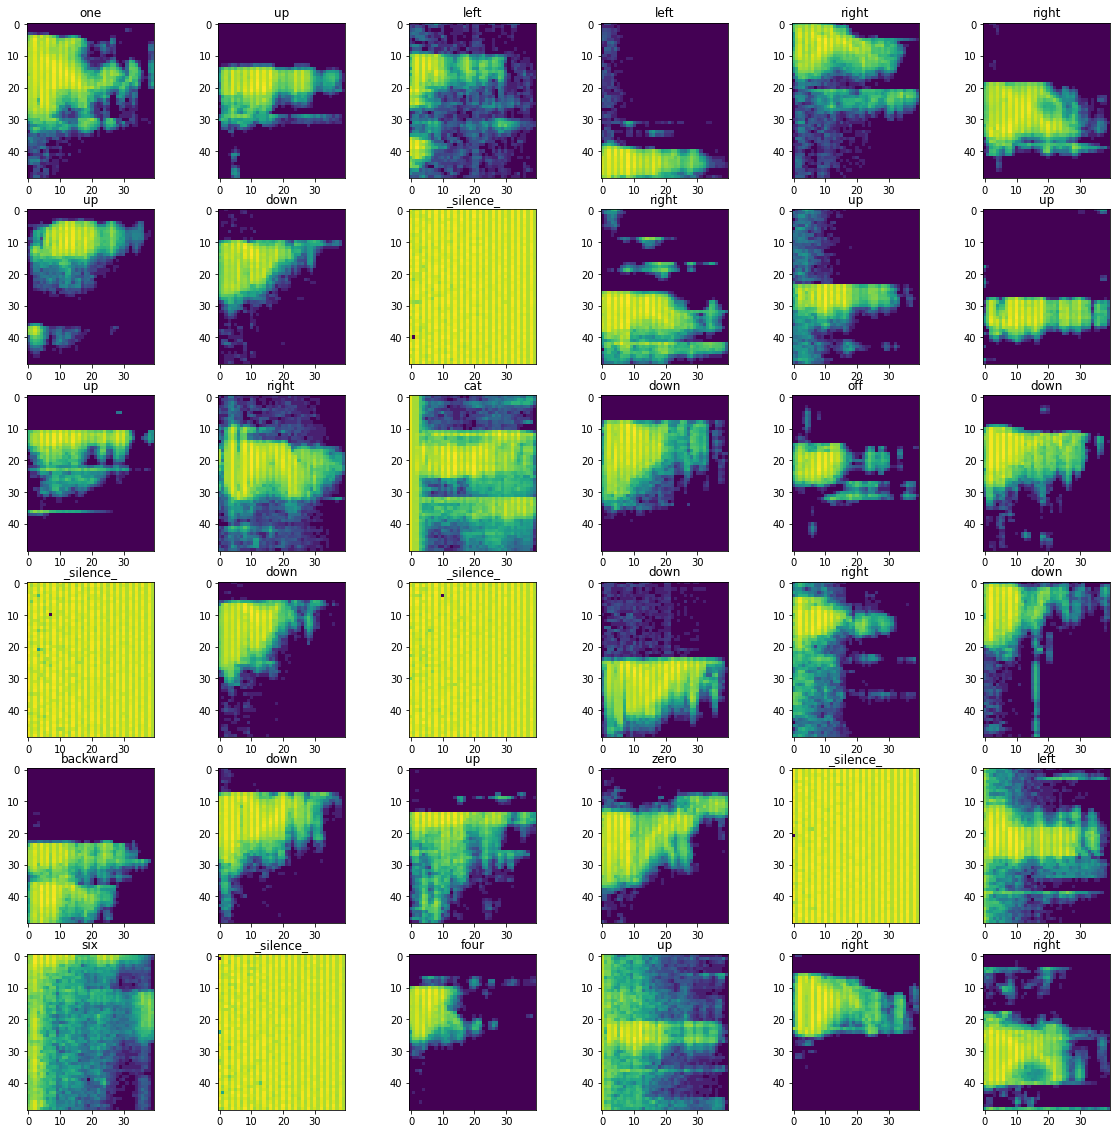

In [37]:
f, a =plt.subplots(6,6, figsize=(20,20))
for k in range(36):
    a.flatten()[k].imshow(np.reshape(audio_processor.specs["training"][k]["spec"], [49, 40]))
    a.flatten()[k].set_title(audio_processor.specs["training"][k]["label"])

In [13]:
audio_processor.words_list

['_silence_', '_unknown_', 'yles', 'alla', 'parem', 'vasak']

In [22]:
unknown_words

['learn', 'happy', 'house', 'forward', 'four']

In [23]:
audio_processor.words_list

['_silence_', '_unknown_', 'yles', 'alla', 'parem', 'vasak']

In [33]:
i_example

'learn'

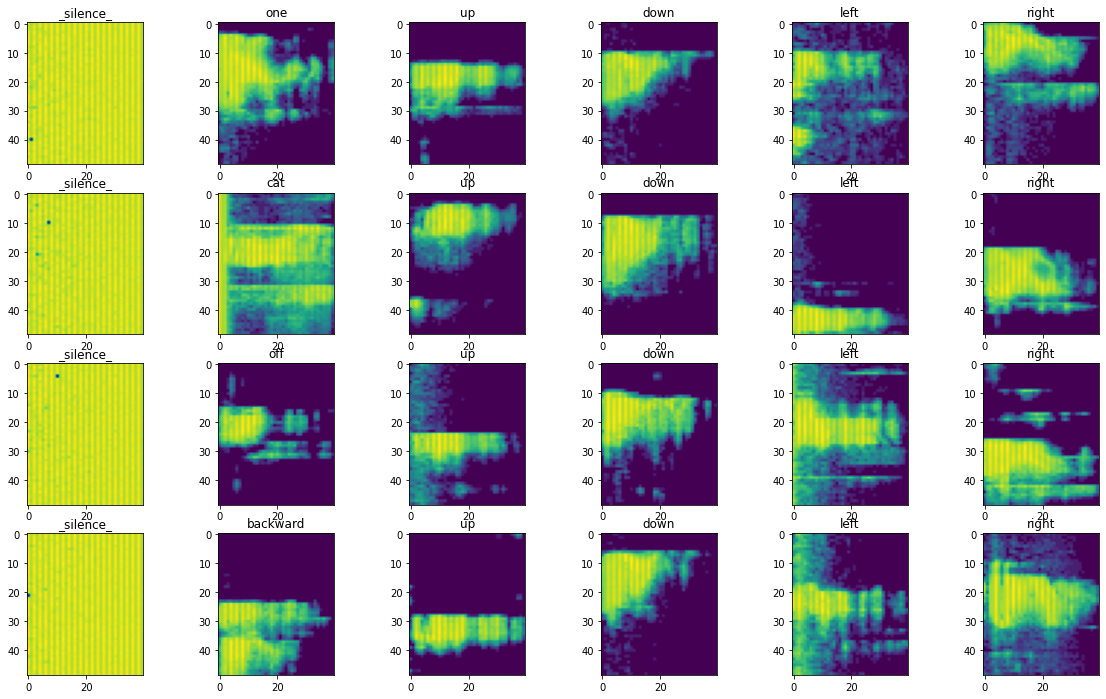

In [38]:
f, a =plt.subplots(4,6, figsize=(20,12))

spec_labels = np.array([spec_dict["label"] for spec_dict in audio_processor.specs["training"]])
unknown_words = [k for k, v in audio_processor.word_to_index.items() if v==1]

for i_word, word in enumerate(audio_processor.words_list):
    
    if word != "_unknown_":
        i_to_use = np.argwhere(spec_labels==word).flatten()
    else:
        i_to_use = []
        for i_spec_label, spec_label in enumerate(spec_labels):
            if spec_label in unknown_words:
                i_to_use.append(i_spec_label)
    
    for i_row, i_example in enumerate(i_to_use[:4]):
        a[i_row, i_word].imshow(np.reshape(audio_processor.specs["training"][i_example]["spec"], [49, 40]))
        a[i_row, i_word].set_title(audio_processor.specs["training"][i_example]["label"])

In [29]:
sample_rate = 16000
window_size_samples = 480
window_stride_samples = 320
num_channels = 40
lower_band_limit = 0.0
upper_band_limit = 7999.0
min_signal_remaining=0.05
smoothing_bits=10
even_smoothing=0.025
odd_smoothing=0.06
enable_pcan=True
pcan_strength=0.95
pcan_offset=80.0
gain_bits=21
scale_shift=6
enable_log=True

tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()

window_size_ms = window_size_samples*1000/sample_rate
window_step_ms = window_stride_samples*1000/sample_rate

with tf.compat.v1.get_default_graph().name_scope('data'):
    wav_filename_placeholder_ = tf.compat.v1.placeholder(tf.string, [], name='wav_filename')
    num_channels_placeholder_ = tf.compat.v1.placeholder(tf.int16, [], name='wav_filename')
    # wav_content_placeholder = tf.placeholder(tf.int16, shape=(None, 1)) # TODO: find the shape of the wav data

    # Read WAV
    wav_loader = io_ops.read_file(wav_filename_placeholder_)

    # Decode a 16-bit PCM WAV file to a float tensor (between -1, +1)
    wav_decoder = tf.audio.decode_wav(wav_loader, desired_channels=1, desired_samples=sample_rate)

    # Extracts a 1-second slice (since there are sample_rate samples) from a tensor: (input, begin, size)
    time_shift_offset_placeholder_ = tf.compat.v1.placeholder(tf.int32, shape=[2], name='time_shift_offset')
    sliced_foreground = tf.slice(wav_decoder.audio, time_shift_offset_placeholder_, [sample_rate, -1])

    f32_input = tf.multiply(sliced_foreground, 32768)
    int16_input = tf.cast(f32_input, tf.int16)

    int16_input_shape = tf.shape(int16_input)

    micro_frontend = frontend_op.audio_microfrontend(int16_input,  sample_rate=16000, 
        # Step 1: WINDOWING
        window_size=window_size_ms, window_step=window_step_ms, num_channels=num_channels, 
        # Step 3: MEL
        upper_band_limit=upper_band_limit, lower_band_limit=lower_band_limit,
        # Step 4: SMOOTHING
        min_signal_remaining=min_signal_remaining, smoothing_bits=smoothing_bits, 
        even_smoothing=even_smoothing, odd_smoothing=odd_smoothing,
        # Step 5: PCAN
        enable_pcan=enable_pcan, pcan_strength=pcan_strength, pcan_offset=pcan_offset, gain_bits=gain_bits,
        # Step 6: LOG-SCALE
        enable_log=enable_log, scale_shift=scale_shift, out_scale=1, out_type=tf.float32)

    output_ = tf.multiply(micro_frontend, (10.0 / 256.0))
    #output_ = tf.multiply(micro_frontend, 1.0)

def compute(wav_filename):
    
    sample_rate, voice_signal = wavfile.read(wav_filename)
    voice_signal_normalised = (voice_signal-np.min(voice_signal))/(np.max(voice_signal)-np.min(voice_signal))
    voice_signal_f32 = voice_signal_normalised*32768

    input_dict = {wav_filename_placeholder_: wav_filename, time_shift_offset_placeholder_: [0, 0]}
    # Run the graph to produce the output audio.
    with tf.Session() as sess:
        [tf_micro_frontend, input_shape, tf_fg, tf_f32_input] = sess.run([output_, int16_input_shape, 
                                                                     sliced_foreground, f32_input], 
                                                                    feed_dict=input_dict)
    return tf_micro_frontend

In [3]:
def get_model_details():
    
        # Load TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(
        model_path=("/Users/meelislootus/Documents/hotg/rune_new2/rune/examples/"
                    "microspeech/model_2048_up_down_right_left.tflite"))
        #model_path="/Users/meelislootus/Documents/hotg/rune/examples/microspeech/model.tflite")
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    return input_details, output_details


def run_tflite_model(input_spectrogram):

    # Load TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(
        model_path=("/Users/meelislootus/Documents/hotg/rune_new2/rune/examples/microspeech/"
        "model_2048_up_down_right_left.tflite"))
        #model_path="/Users/meelislootus/Documents/hotg/rune/examples/microspeech/model.tflite")
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Test model on input data.
    interpreter.set_tensor(input_details[0]['index'], input_spectrogram)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

In [90]:
#output = (255*(output-np.min(output))/(np.max(output)-np.min(output))-128).astype(np.int8)

input_details, output_details = get_model_details()

input_scale, input_zero_point = input_details[0]["quantization"]

yes_dir = "/Users/meelislootus/Documents/hotg/tflite_models/microspeech/dataset/right"
no_dir = "/Users/meelislootus/Documents/hotg/tflite_models/microspeech/dataset/no"
yes_list = os.listdir(yes_dir)
no_list = os.listdir(no_dir)

tf_result_list = []
rune_result_list = []

for yes in yes_list[0:50]:

    if True:
        output = compute(os.path.join(yes_dir, yes))

        test_data = output.flatten() / input_scale + input_zero_point
        test_data = np.reshape(test_data.astype(input_details[0]["dtype"]), [1, 1960])
        tf_result_list.append(run_tflite_model(test_data))
    
    if True:
        samplerate, data = wavfile.read(os.path.join(yes_dir, yes))
        #data = (32768*data.astype(np.float32)/np.max(abs(data))).astype(np.int16)
        
        fft = Fft()
        noise_filtering = NoiseFiltering()

        fft.sample_rate = 16000
        noise_filtering.smoothing_bits = 10
        noise_filtering.even_smoothing = 0.025
        noise_filtering.odd_smoothing = 0.06
        noise_filtering.min_signal_remaining = 0.05
        noise_filtering.strength = 0.95
        noise_filtering.offset = 80.0
        noise_filtering.gain_bits = 21

        rune_spec = noise_filtering(fft(data))
        rune_result_list.append(run_tflite_model(np.reshape(rune_spec, [1, 1960])))
    

/Users/meelislootus/Documents/hotg/tflite_models/venv_tf1_py3d7d6/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: overflow encountered in short_scalars


In [91]:
print("TF truth: {}".format(np.sum(np.argmax(np.vstack(tf_result_list), axis=1)==2)/len(tf_result_list)))
print("Rune truth: {}".format(np.sum(np.argmax(np.vstack(rune_result_list), axis=1)==2)/len(rune_result_list)))

TF truth: 0.06
Rune truth: 0.08


# Archive

In [121]:
def compute_rune_spec(data):
    
    fft = Fft()
    noise_filtering = NoiseFiltering()

    fft.sample_rate = 16000
    noise_filtering.smoothing_bits = 10
    noise_filtering.even_smoothing = 0.025
    noise_filtering.odd_smoothing = 0.06
    noise_filtering.min_signal_remaining = 0.05
    noise_filtering.strength = 0.95
    noise_filtering.offset = 80.0
    noise_filtering.gain_bits = 21

    rune_spec = noise_filtering(fft(data))
    return rune_spec

data_dict = {}


def save_dataset(words_used=["yes", "no"], file_path='data.pkl', samples_per_class=10):
    """ Select samples, and then compute the spectrogram for each sample, using compute_rune_spec """
    
    # Train such that it does not generalise
    base_dir = "/Users/meelislootus/Documents/hotg/tflite_models/microspeech/dataset"
    for word in words_used:
        data_dict[word] = []
        word_dir = os.path.join(base_dir, word)
        word_filenames = os.listdir(word_dir)
        for i_sample in range(samples_per_class):

            i_file = np.random.randint(0, len(word_filenames))
            sample_path = os.path.join(word_dir, word_filenames[i_file])
            sample_rate, signal = wavfile.read(sample_path)

            data_dict[word].append(compute_rune_spec(signal))

    # Silence
    data_dict["silence"] = []
    for i_sample in range(samples_per_class):

        i_file = np.random.randint(0, len(word_filenames))
        sample_path = os.path.join(word_dir, word_filenames[i_file])
        sample_rate, signal = wavfile.read(sample_path)

        spec = compute_rune_spec(np.random.randint(-32768, 32767, [1, 16000]))
        data_dict["silence"].append(spec)

    # Random noise    
    noise_dir = os.path.join(base_dir, "_background_noise_")
    noise_filenames = os.listdir(noise_dir)
    noise_filenames.remove("README.md")
    loaded_noises = []
    for i_file in range(len(noise_filenames)):
        _, noise = wavfile.read(os.path.join(noise_dir, noise_filenames[i_file]))
        loaded_noises.append(noise)

    data_dict["noise"] = []
    for i_sample in range(samples_per_class):

        i_noise = np.random.randint(0, len(loaded_noises))
        selected_noise = loaded_noises[i_noise]

        i_noise_start = np.random.randint(0, len(selected_noise)-16000)
        noise_segment = selected_noise[i_noise_start:(i_noise_start+16000)]

        spec = compute_rune_spec(noise_segment)
        data_dict["noise"].append(spec)
        
    with open(file_path, 'wb') as f:
        pickle.dump(data_dict, f)

save_dataset()

/Users/meelislootus/Documents/hotg/tflite_models/venv_tf1_py3d7d6/lib/python3.7/site-packages/ipykernel_launcher.py:53: WavFileWarning: Chunk (non-data) not understood, skipping it.


In [ ]:
def get_data_mock(num_samples, offset, model_settings, background_frequency, background_volume, time_shift_samples,
                  data_fold, sess):

    mock_fingerprints = np.random.uniform(
        low=0.0, high=26.0, size=(num_samples, 1960))
    mock_ground_truth = np.random.choice(
        range(6), size=num_samples, replace=True)

    return mock_fingerprints, mock_ground_truth